In [6]:
import numpy as np
import numpy.typing as npt
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image

In [7]:
TEXTURE_WIDTH = 8
TEXTURE_HEIGHT = 8

TEXTURE_MEMORY_START = 0x9000

compressed: bool = True

atlas_path = Path.cwd() / "snake_textures.png"

colors = np.array([
    [0x00, 0x00, 0x00, 0xFF],
    [0x1D, 0x2B, 0x53, 0xFF],
    [0x7E, 0x25, 0x53, 0xFF],
    [0x00, 0x87, 0x51, 0xFF],
    [0xAB, 0x52, 0x36, 0xFF],
    [0x5F, 0x57, 0x4F, 0xFF],
    [0xC2, 0xC3, 0xC7, 0xFF],
    [0xFF, 0xF1, 0xE8, 0xFF],
    [0xFF, 0x00, 0x4D, 0xFF],
    [0xFF, 0xA3, 0x00, 0xFF],
    [0xFF, 0xEC, 0x27, 0xFF],
    [0x00, 0xE4, 0x36, 0xFF],
    [0x29, 0xAD, 0xFF, 0xFF],
    [0x83, 0x76, 0x9C, 0xFF],
    [0xFF, 0x77, 0xA8, 0xFF],
    [0xFF, 0xCC, 0xAA, 0xFF],
])

TEXTURE_PREFIX = "TEXTURE_"
TILE_PREFIX = "TILE_"
tile_names: dict[tuple[int, int], str] = {
    ( 0,  0): "EMPTY",
    ( 0,  4): "APPLE",
    ( 1,  4): "APPLE_GOLDEN",
    ( 0,  8): "WALL",
    ( 1,  8): "HAZARD",
    ( 0, 10): "SNAKE_HEAD_R_",
    ( 4, 10): "SNAKE_HEAD_L_",
    ( 8, 10): "SNAKE_HEAD_D_",
    (12, 10): "SNAKE_HEAD_U_",
    ( 0, 11): "SNAKE_BODY_RR",
    ( 1, 11): "SNAKE_BODY_RL",
    ( 2, 11): "SNAKE_BODY_RD",
    ( 3, 11): "SNAKE_BODY_RU",
    ( 4, 11): "SNAKE_BODY_LR",
    ( 5, 11): "SNAKE_BODY_LL",
    ( 6, 11): "SNAKE_BODY_LD",
    ( 7, 11): "SNAKE_BODY_LU",
    ( 8, 11): "SNAKE_BODY_DR",
    ( 9, 11): "SNAKE_BODY_DL",
    (10, 11): "SNAKE_BODY_DD",
    (11, 11): "SNAKE_BODY_DU",
    (12, 11): "SNAKE_BODY_UR",
    (13, 11): "SNAKE_BODY_UL",
    (14, 11): "SNAKE_BODY_UD",
    (15, 11): "SNAKE_BODY_UU",
    ( 0,  9): "SNAKE_TAIL__R",
    ( 1,  9): "SNAKE_TAIL__L",
    ( 2,  9): "SNAKE_TAIL__D",
    ( 3,  9): "SNAKE_TAIL__U",
    ( 0, 12): "FONT_0",
    ( 1, 12): "FONT_1",
    ( 2, 12): "FONT_2",
    ( 3, 12): "FONT_3",
    ( 4, 12): "FONT_4",
    ( 5, 12): "FONT_5",
    ( 6, 12): "FONT_6",
    ( 7, 12): "FONT_7",
    ( 8, 12): "FONT_8",
    ( 9, 12): "FONT_9",
    (10, 12): "FONT_A",
    (11, 12): "FONT_B",
    (12, 12): "FONT_C",
    (13, 12): "FONT_D",
    (14, 12): "FONT_E",
    (15, 12): "FONT_F",
    ( 0, 13): "FONT_G",
    ( 1, 13): "FONT_H",
    ( 2, 13): "FONT_I",
    ( 3, 13): "FONT_J",
    ( 4, 13): "FONT_K",
    ( 5, 13): "FONT_L",
    ( 6, 13): "FONT_M",
    ( 7, 13): "FONT_N",
    ( 8, 13): "FONT_O",
    ( 9, 13): "FONT_P",
    (10, 13): "FONT_Q",
    (11, 13): "FONT_R",
    (12, 13): "FONT_S",
    (13, 13): "FONT_T",
    (14, 13): "FONT_U",
    (15, 13): "FONT_V",
    (10, 14): "FONT_W",
    (11, 14): "FONT_X",
    (12, 14): "FONT_Y",
    (13, 14): "FONT_Z",
    (14, 14): "FONT_COLON",
    (15, 14): "FONT_SPACE",
}

Loaded 16 x 16 atlas


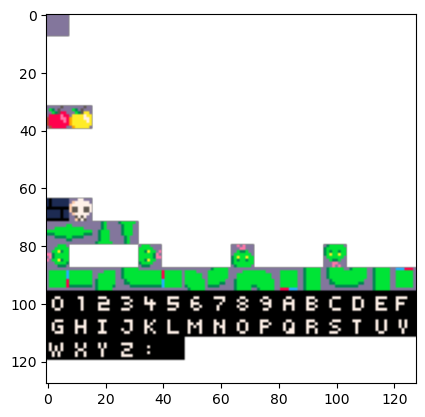

In [8]:
atlas_image = Image.open(atlas_path)
atlas_texture = np.array(atlas_image.getdata()).reshape((atlas_image.height, atlas_image.width, -1))
n_textures_x = atlas_image.width // TEXTURE_WIDTH
n_textures_y = atlas_image.height // TEXTURE_HEIGHT
print(f"Loaded {n_textures_x} x {n_textures_y} atlas")

plt.figure()
plt.imshow(atlas_texture)
plt.show()

In [9]:
texture_definitions: dict[int, npt.NDArray[np.uint8]] = {}
for texture_y in range(n_textures_y):
    for texture_x in range(n_textures_x):
        pixel_x_from = texture_x * TEXTURE_WIDTH
        pixel_x_to   = (texture_x + 1) * TEXTURE_WIDTH
        pixel_y_from = texture_y * TEXTURE_HEIGHT
        pixel_y_to   = (texture_y + 1) * TEXTURE_HEIGHT
        texture = atlas_texture[pixel_y_from:pixel_y_to, pixel_x_from:pixel_x_to, :]

        # Skip empty textures.
        if np.all(texture == 0):
            continue

        # plt.figure()
        # plt.imshow(texture)
        # plt.show()

        indices = np.zeros((TEXTURE_HEIGHT, TEXTURE_WIDTH), dtype=np.uint8)
        for x in range(TEXTURE_WIDTH):
            for y in range(TEXTURE_HEIGHT):
                indices[y, x] = np.where(np.all(texture[y, x, :] == colors, axis=1))[0][0]
        texture_definitions[texture_y * n_textures_x + texture_x] = indices

In [10]:
texture_definition_size: int = 32 if compressed else 64
i_memory = TEXTURE_MEMORY_START

with open("output.axm", "w") as file:
    for index, indices in texture_definitions.items():
        x_texture = index % n_textures_x
        y_texture = index // n_textures_x
        name = tile_names.get((x_texture, y_texture), f"0x{index:02X}")
        texture_name = f"{TEXTURE_PREFIX}{name}"
        tile_name = f"{TILE_PREFIX}{name}"

        if compressed:
            text = '\n    '.join(['; '.join([f"0x{(indices[y, 2*x] & 0x0F) | ((indices[y, 2*x + 1] << 4) & 0xF0):02X}" for x in range(TEXTURE_WIDTH // 2)]) for y in range(TEXTURE_HEIGHT)])
        else:
            text = '\n    '.join(['; '.join([f"0x{indices[y, x]:02X}" for x in range(TEXTURE_WIDTH)]) for y in range(TEXTURE_HEIGHT)])

        print(f"${tile_name} := 0x{index:02X}", file=file)
        print(f"${texture_name} := 0x{i_memory:04X}", file=file)
        print(f"!at 0x{i_memory:04X} {'{'}", file=file)
        print(f"    {text}", file=file)
        print("}", file=file)
        print("", file=file)
        i_memory += texture_definition_size